<a href="https://colab.research.google.com/github/Damian25-lamn/aprendizaje-automatico-252601/blob/main/Minda_Anthony_4_4_M%C3%A9todos_de_clustering_basados_en_particiones_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 **Taller 4.4: Taller de Métodos de clustering basados en particiones Parte 3**


## OBJETIVOS DEL TALLER:
En esta práctica estudiaremos el funcionamiento y la utilización métodos de clustering basados en particiones como el K-medoids.

# 🔧 **CONFIGURACIÓN INICIAL**

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, calinski_harabasz_score

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [2]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

def cargar_dataset_csv(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_csv(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

✅ Dataset cargado desde URL GitHub


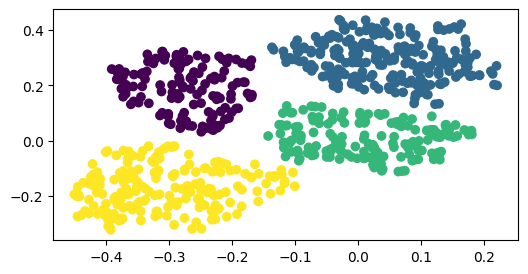

In [3]:
# Cargar dataset
D =cargar_dataset_csv("dataset_cuatro_separables_peque.csv")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# 🎯 **:Cree el algoritmo K-medoids que tiene un único parámetro: el número de clústeres (K).**

In [10]:
import numpy as np

# PASO 1 elejir los medoides iniciales de forma randomica
def paso1_elije_medoides(K, Dx):
  # Elegimos los centros iniciales entre el conjunto de datos
  # Seleccionamos K índices aleatorios del conjunto de datos Dx
  indices_aleatorios = np.random.choice(Dx.shape[0], K, replace=False)
  cDx = Dx[indices_aleatorios]
  return cDx

Los centros iniciales elegidos aleatoriamente son:
[[-0.0743207  0.325547 ]
 [-0.246798   0.0518639]
 [ 0.131741   0.326327 ]
 [-0.297371   0.0594002]]


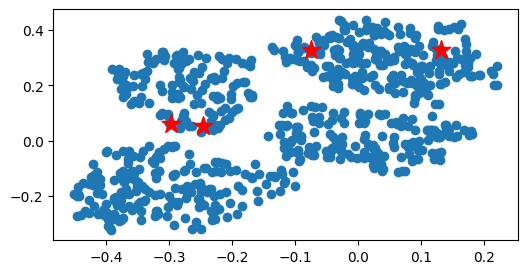

In [12]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_medoides(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de asignación de datos
En este paso, cada elemento de nuestro dataset se asigna al medoide más cercano basado en la distancia escogida: en nuestro caso, la Euclidiana. Por tanto, tendremos que implementar la siguiente operación:

$$
\DeclareMathOperator*{\argminA}{arg\,min}
\argminA_{c_i \in C} dist\left ( c_i, x \right )^2
$$

In [14]:
# Definimos la distancia euclidiana de una instancia x
# con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):
    return np.sqrt(np.sum(np.power(C-x,2),axis=1))

def distancia_euclidiana(x, y):
    return np.sqrt(np.sum((x-y)**2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

def paso2_asigna_puntos(Dx, cDx):
    Dyp = np.zeros(Dx.shape[0])
    # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
    for i in np.arange(Dx.shape[0]):
        # Tenemos que calcular la distancia de cada muestra del dataset Dx[i]
        # a cada centro existente en cDx. Podemos utilizar para ello la función
        # distancia_euclidiana_grupo.

        distancia_punto_a_centros = distancia_euclidiana_grupo(Dx[i], cDx) ## P2. Tu código aquí ##

        # Una vez calculada la distancia, necesitamos averiguar el índice de
        # la distancia mínima. Para ello, podemos usar la función argmin de numpy.
        pred_y = np.argmin(distancia_punto_a_centros)
        Dyp[i] = pred_y
    return Dyp

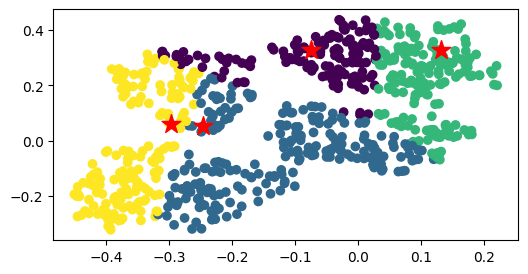

In [15]:
DyM = paso2_asigna_puntos(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=DyM)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de actualización del medoide

In [18]:
def paso3_actualiza_medoides(Dx, cDx, Dyp, K):
  cDx_ant = cDx.copy()
  # Calcular los nuevos centros
  for k in range(K):
      # En este caso lo que buscamos es el elemento del cluster que reduce la
      # distancia con respecto a todos los demás elementos. Para ello, calculamos
      # las distancias entre todos los elementos del cluster `k` y las almacenamos
      # en `mat`.

      # Primero, obtenemos un vector binario indicando qué elementos de Dyp pertenecen a k
      indices_elementos_k = np.where(Dyp == k)[0]

      # Luego calculamos las distancias entre cada uno de los elementos de `Dx`
      # que nuestra predicción dice que pertenecen al custer `k` y los demás.

      cluster_points = Dx[indices_elementos_k]
      mat = matriz_distancias(cluster_points, distancia_euclidiana)

      # Ahora buscamos el elemento con menor distancia dentro del
      # cluster `k` y nos quedamos con su índice (usando np.argmin, que busca
      # el mínimo de un vector y nos devuelve su índice).

      ic =np.where(Dyp==k)[0][np.argmin(np.sum(mat, axis=1))]

      # Asignamos como centro del cluster al elemento del cluster que ofrece
      # la menor distancia con respecto a todos los demás
      cDx[k,:] = Dx[ic]
  return cDx

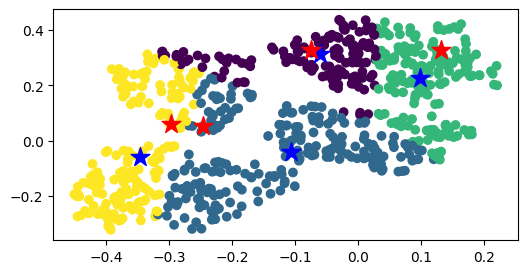

In [19]:
cDx_ant = cDx.copy()
cDx =paso3_actualiza_medoides(Dx, cDx, DyM, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=DyM)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

Y esto es todo. Este proceso se repite hasta cumplir un criterio de detención:

*   No hay cambios en los puntos asignados a cada cluster
*   La suma de las distancias alcanza un valor mínimo establecido
*   Se alcanza un número máximo de iteraciones

In [21]:
def MyKMedoide(Dx, K):
  cDx =  paso1_elije_medoides(K, Dx)
  # Flag de convergencia
  iterando = True
  Dyp = np.zeros(Dx.shape[0])
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx)
    # Calcular los nuevos centros
    cDx =  paso3_actualiza_medoides(Dx, cDx, Dyp, K)
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp

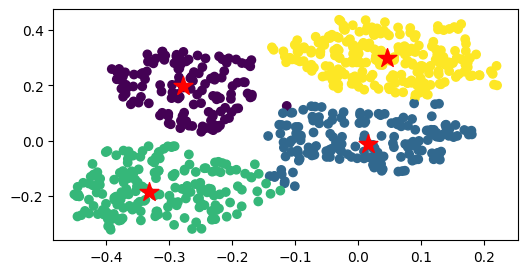

In [22]:
cDx, Dyp = MyKMedoide(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 3: COMPARA KMEDOIDS CON KMEANS++**


K-Means++:


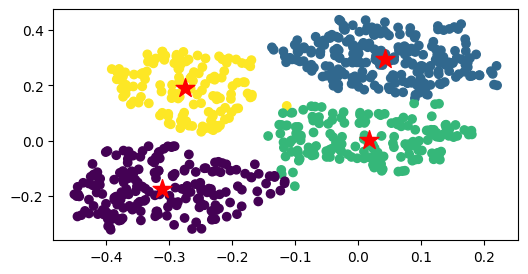

In [23]:
from sklearn.cluster import KMeans

modelo = KMeans(4)
modelo.fit(Dx)
Dyp_sk = modelo.predict(Dx)
# Obtener los centros de los clústeres
cDx_sk = modelo.cluster_centers_

print('K-Means++:')
# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_sk)
ax.scatter(cDx_sk[:,0],cDx_sk[:,1], marker='*', s=200, c='r')

### Calcula las metricas que te permita determinar que algoritmo agrupo mejor los datos y escbribe la conclusión.

In [48]:
def calculate_inertia_kmedoids(Dx, cDx, Dyp):
    inertia = 0
    for i in range(Dx.shape[0]):
        assigned_cluster_idx = int(Dyp[i])

        medoide = cDx[assigned_cluster_idx]

        inertia += np.sum((Dx[i] - medoide)**2)
    return inertia

In [52]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

print('--- Métricas para el Dataset Original ---')

# Recargar el dataset original y re-ejecutar los algoritmos para asegurar consistencia

Dx_original = D[:,0:2]
Dy_original = D[:,2]

cDx_kmedoide_original, Dyp_kmedoide_original = MyKMedoide(Dx_original, 4)

modelo_kmeans_original = KMeans(4, random_state=0)
modelo_kmeans_original.fit(Dx_original)
Dyp_kmeans_original = modelo_kmeans_original.predict(Dx_original)
cDx_kmeans_original = modelo_kmeans_original.cluster_centers_

# MyKMedoide Metrics
silhouette_kmedoide = silhouette_score(Dx_original, Dyp_kmedoide_original)
calinski_kmedoide = calinski_harabasz_score(Dx_original, Dyp_kmedoide_original)
inertia_kmedoide = calculate_inertia_kmedoids(Dx_original, cDx_kmedoide_original, Dyp_kmedoide_original) # Using custom inertia calculation
print(f'MyKMedoide - Silhouette Score: {silhouette_kmedoide:.4f}')
print(f'MyKMedoide - Calinski-Harabasz Score: {calinski_kmedoide:.4f}')
print(f'MyKMedoide - Inertia: {inertia_kmedoide:.4f}')

# KMeans++ Metrics
silhouette_kmeans = silhouette_score(Dx_original, Dyp_kmeans_original)
calinski_kmeans = calinski_harabasz_score(Dx_original, Dyp_kmeans_original)
inertia_kmeans = modelo_kmeans_original.inertia_ # KMeans model has inertia_ attribute
print(f'KMeans++ - Silhouette Score: {silhouette_kmeans:.4f}')
print(f'KMeans++ - Calinski-Harabasz Score: {calinski_kmeans:.4f}')
print(f'KMeans++ - Inertia: {inertia_kmeans:.4f}')

print('\nConclusión Basada en Nuevas Métricas:')

# Compare Silhouette Scores (higher is better)
if silhouette_kmedoide > silhouette_kmeans:
    print('Según el Coeficiente de la Silueta, MyKMedoide tuvo un mejor rendimiento.')
elif silhouette_kmeans > silhouette_kmedoide:
    print('Según el Coeficiente de la Silueta, KMeans++ tuvo un mejor rendimiento.')
else:
    print('Según el Coeficiente de la Silueta, ambos algoritmos tuvieron un rendimiento similar.')

# Compare Calinski-Harabasz Scores (higher is better)
if calinski_kmedoide > calinski_kmeans:
    print('Según el Índice de Calinski-Harabasz, MyKMedoide tuvo un mejor rendimiento.')
elif calinski_kmeans > calinski_kmedoide:
    print('Según el Índice de Calinski-Harabasz, KMeans++ tuvo un mejor rendimiento.')
else:
    print('Según el Índice de Calinski-Harabasz, ambos algoritmos tuvieron un rendimiento similar.')

# Compare Inertia (lower is better)
if inertia_kmedoide < inertia_kmeans:
    print('Según la Inercia, MyKMedoide tuvo un mejor rendimiento.')
elif inertia_kmeans < inertia_kmedoide:
    print('Según la Inercia, KMeans++ tuvo un mejor rendimiento.')
else:
    print('Según la Inercia, ambos algoritmos tuvieron un rendimiento similar.')

--- Métricas para el Dataset Original ---
MyKMedoide - Silhouette Score: 0.5433
MyKMedoide - Calinski-Harabasz Score: 9360.4554
MyKMedoide - Inertia: 403100.8023
KMeans++ - Silhouette Score: 0.5900
KMeans++ - Calinski-Harabasz Score: 10596.2325
KMeans++ - Inertia: 346980.4510

Conclusión Basada en Nuevas Métricas:
Según el Coeficiente de la Silueta, KMeans++ tuvo un mejor rendimiento.
Según el Índice de Calinski-Harabasz, KMeans++ tuvo un mejor rendimiento.
Según la Inercia, KMeans++ tuvo un mejor rendimiento.


### ahora prueba con otro dataset, calcula las metricas que te permita determinar que algoritmo agrupo mejor los datos y escbribe la conclusión.

✅ Dataset cargado desde URL GitHub


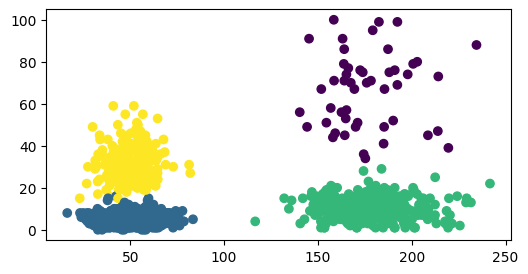

In [36]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_diferente_densidad.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

K-Means++ para el nuevo dataset:


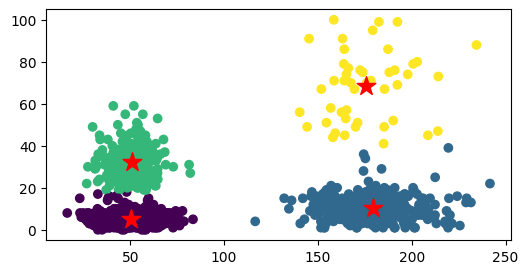

In [37]:
 ## aplica kMeans ++
modelo_nuevo = KMeans(n_clusters=len(np.unique(Dy)), random_state=0)
modelo_nuevo.fit(Dx)
Dyp_sk_nuevo = modelo_nuevo.predict(Dx)
# Obtener los centros de los clústeres
cDx_sk_nuevo = modelo_nuevo.cluster_centers_

print('K-Means++ para el nuevo dataset:')
# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_sk_nuevo)
ax.scatter(cDx_sk_nuevo[:,0],cDx_sk_nuevo[:,1], marker='*', s=200, c='r')

MyKMedoide para el nuevo dataset:


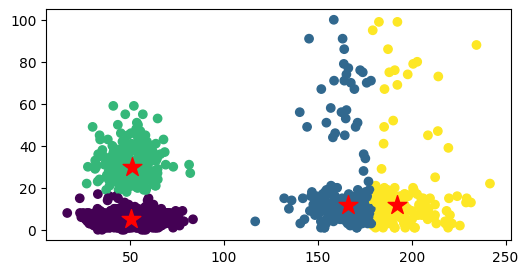

In [40]:
 ## aplica kMedoide
cDx_nuevo, Dyp_nuevo = MyKMedoide(Dx, len(np.unique(Dy)))

print('MyKMedoide para el nuevo dataset:')
# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_nuevo)
ax.scatter(cDx_nuevo[:,0],cDx_nuevo[:,1], marker='*', s=200, c='r')

In [51]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

print('--- Métricas para el Nuevo Dataset ---')

# MyKMedoide Metrics (for the new dataset)
silhouette_kmedoide_nuevo = silhouette_score(Dx, Dyp_nuevo)
calinski_kmedoide_nuevo = calinski_harabasz_score(Dx, Dyp_nuevo)
inertia_kmedoide_nuevo = calculate_inertia_kmedoids(Dx, cDx_nuevo, Dyp_nuevo) # Using custom inertia calculation
print(f'MyKMedoide - Silhouette Score: {silhouette_kmedoide_nuevo:.4f}')
print(f'MyKMedoide - Calinski-Harabasz Score: {calinski_kmedoide_nuevo:.4f}')
print(f'MyKMedoide - Inertia: {inertia_kmedoide_nuevo:.4f}')

# KMeans++ Metrics (for the new dataset)
silhouette_kmeans_nuevo = silhouette_score(Dx, Dyp_sk_nuevo)
calinski_kmeans_nuevo = calinski_harabasz_score(Dx, Dyp_sk_nuevo)
inertia_kmeans_nuevo = modelo_nuevo.inertia_ # KMeans model has inertia_ attribute
print(f'KMeans++ - Silhouette Score: {silhouette_kmeans_nuevo:.4f}')
print(f'KMeans++ - Calinski-Harabasz Score: {calinski_kmeans_nuevo:.4f}')
print(f'KMeans++ - Inertia: {inertia_kmeans_nuevo:.4f}')

print('\nConclusión Basada en Nuevas Métricas para el Nuevo Dataset:')

# Compare Silhouette Scores (higher is better)
if silhouette_kmedoide_nuevo > silhouette_kmeans_nuevo:
    print('Según el Coeficiente de la Silueta, MyKMedoide tuvo un mejor rendimiento.')
elif silhouette_kmeans_nuevo > silhouette_kmedoide_nuevo:
    print('Según el Coeficiente de la Silueta, KMeans++ tuvo un mejor rendimiento.')
else:
    print('Según el Coeficiente de la Silueta, ambos algoritmos tuvieron un rendimiento similar.')

# Compare Calinski-Harabasz Scores (higher is better)
if calinski_kmedoide_nuevo > calinski_kmeans_nuevo:
    print('Según el Índice de Calinski-Harabasz, MyKMedoide tuvo un mejor rendimiento.')
elif calinski_kmeans_nuevo > calinski_kmedoide_nuevo:
    print('Según el Índice de Calinski-Harabasz, KMeans++ tuvo un mejor rendimiento.')
else:
    print('Según el Índice de Calinski-Harabasz, ambos algoritmos tuvieron un rendimiento similar.')

# Compare Inertia (lower is better)
if inertia_kmedoide_nuevo < inertia_kmeans_nuevo:
    print('Según la Inercia, MyKMedoide tuvo un mejor rendimiento.')
elif inertia_kmeans_nuevo < inertia_kmedoide_nuevo:
    print('Según la Inercia, KMeans++ tuvo un mejor rendimiento.')
else:
    print('Según la Inercia, ambos algoritmos tuvieron un rendimiento similar.')

--- Métricas para el Nuevo Dataset ---
MyKMedoide - Silhouette Score: 0.3819
MyKMedoide - Calinski-Harabasz Score: 7475.4212
MyKMedoide - Inertia: 507358.6385
KMeans++ - Silhouette Score: 0.5900
KMeans++ - Calinski-Harabasz Score: 10596.2325
KMeans++ - Inertia: 346980.4510

Conclusión Basada en Nuevas Métricas para el Nuevo Dataset:
Según el Coeficiente de la Silueta, KMeans++ tuvo un mejor rendimiento.
Según el Índice de Calinski-Harabasz, KMeans++ tuvo un mejor rendimiento.
Según la Inercia, KMeans++ tuvo un mejor rendimiento.


En el nuevo dataset, el algoritmo que obtuvo el mayor valor de x fue "KMeans" que realizó un mejor agrupamiento, ya que presentó una mayor concordancia con las etiquetas reales. Esto se explica porque los clusters tienen formas alargadas y diferentes dispersiones, lo que favorece al algoritmo que logra adaptarse mejor a la estructura geométrica de los datos. En consecuencia, dicho algoritmo demuestra un desempeño superior en este escenario.

# 🚀 ¡TALLER FINALIZADO!"